In [1]:
%matplotlib inline
%pylab
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config InlineBackend.figure_format='retina'

import numpy as np
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
import seaborn as sns
from scipy.optimize import curve_fit

from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm
from Xana import Soq

from glob import glob
from Xana import CorrFunc
from Xana.Xfit.fitg2global import G2
from Xana.Xfit.fit_basic import fit_basic
from Xana.misc.add_colorbar import add_colorbar
import configparser

import pandas as pd
import pickle
import h5py

Using matplotlib backend: <object object at 0x2abe1abe58b0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Functions

In [2]:
def linear(x,m,q):
    return m*x + q

Kb = 1 #1.380649e-23 #m2 kg s-2 K-1

def VFT(x,t1,B,T0):
    return t1 * np.exp( B * T0/(x - T0) )
    #return t1 * np.exp( B/(x - T0) )

def arrhenius(x,t1,Ea):
    return t1 * np.exp( Ea/(x*Kb) )

def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def gaussian_inv(x, a, x0, sigma, off):
    return -a*np.exp(-(x-x0)**2/(2*sigma**2)) + off
               
def fit(function,x,y,p0=None,sigma=None,bounds=[None,None],xc_len=False):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma,bounds=bounds)
    if xc_len: xc = np.linspace(min(x),max(x),100)
    else: xc = np.linspace(min(x),max(x),len(x))
    curve = function(xc,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,xc,curve,perr

# Load data

In [3]:
!ls ../02-sources/

cmws_chi.npz		HydLys_0p25_1_00001.fio  img_avg_blank.npy
elog			img_1000.npy		 img_avg.npy
fit_params_h25_LLT.npz	img_100_blank.npy	 waxs_temps.npz
fit_params_h25_old.npz	img_100.npy
fit_pars_Temps.pkl	img_1_.npy


In [5]:
f = np.load("../02-sources/fit_params_h25_LLT.npz")
T2 = f['temp']
tau2, dtau2 = f['tau'], f['dtau']
alpha2, dalpha2 = f['alpha'], f['dalpha']

In [6]:
f = np.load("../02-sources/fit_params_h25_old.npz")
print(list(f.files))
T1 = f['temp']
tau1, dtau1 = f['tau'], f['dtau']
alpha1 = f['alphas']

['temp', 'alphas', 'tau', 'dtau']


# Plots

**Distinguish beamtimes**

In [6]:
for i in range(len(T1)):
    if T1[i]==230: print(tau1[i])
    if T2[i]==230: print(tau2[i])

252.28168836893366
189.7990201779569


In [7]:
aa = np.array([252.282, 189.799])
aa.mean()

221.0405

<IPython.core.display.Javascript object>


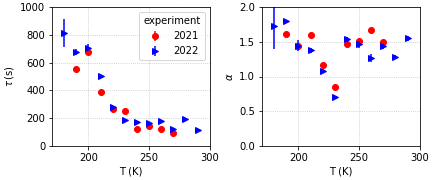

In [8]:
f, (a1,a2) = plt.subplots(1,2, figsize=(6,2.5), constrained_layout=True)

a1.errorbar(T1, tau1, yerr=dtau1, fmt='o',ls='', color='r', label='2021' )
a1.errorbar(T2, tau2, yerr=dtau2, fmt='>',ls='', color='b', label='2022' )

a2.plot(T1, alpha1, marker='o',ls='', color='r', label='2021' )
a2.errorbar(T2, alpha2, yerr=dalpha2, fmt='>',ls='', color='b', label='2022' )

a1.legend(title='experiment')
a1.grid(ls=':',color='gray',alpha=.5)
a1.set_xlim(170,300)
a1.set_ylim(0,1000)
a1.set_xlabel('T (K)')
a1.set_ylabel(r'$\tau\,(\mathrm{s})$')

a2.grid(ls=':',color='gray',alpha=.5)
a2.set_xlim(170,300)
a2.set_ylim(0,2)
a2.set_xlabel('T (K)')
a2.set_ylabel(r'$\alpha$')

f.show()

<IPython.core.display.Javascript object>


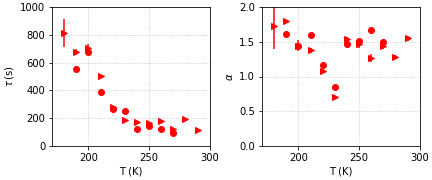

In [9]:
f, (a1,a2) = plt.subplots(1,2, figsize=(6,2.5), constrained_layout=True)

a1.errorbar(T1, tau1, yerr=dtau1, fmt='o',ls='', color='r', label='2021' )
a1.errorbar(T2, tau2, yerr=dtau2, fmt='>',ls='', color='r', label='2022' )

a2.plot(T1, alpha1, marker='o',ls='', color='r', label='2021' )
a2.errorbar(T2, alpha2, yerr=dalpha2, fmt='>',ls='', color='r', label='2022' )

# a1.legend(title='experiment')
a1.grid(ls=':',color='gray',alpha=.5)
a1.set_xlim(170,300)
a1.set_ylim(0,1000)
a1.set_xlabel('T (K)')
a1.set_ylabel(r'$\tau\,(\mathrm{s})$')

a2.grid(ls=':',color='gray',alpha=.5)
a2.set_xlim(170,300)
a2.set_ylim(0,2)
a2.set_xlabel('T (K)')
a2.set_ylabel(r'$\alpha$')

f.show()

In [10]:
T = np.concatenate((T1,T2))

tau = np.concatenate((tau1,tau2))
dtau = np.concatenate((dtau1,dtau2))

alpha = np.concatenate((alpha1,alpha2))
dalpha_fake = np.zeros(len(T1))
dalpha = np.concatenate((dalpha_fake,dalpha2))

**Save data in csv files**

In [11]:
!ls ../csv

Figure2a.csv  Figure2c.csv     Figure3b.csv
Figure2b.csv  Figure2d-2e.csv  Figure3c.csv


In [12]:
fig2de = {'Temperature (K)': T,
          'tau (s)' : tau,
          'error tau (s)': dtau,
          'kww': alpha,
          'error kww': dalpha,
         }

# create dataframe from dictionary
df2de = pd.DataFrame(fig2de)

# write csv from dataframe
df2de.to_csv('../csv/Figure2d-2e.csv', index=False)

# load
rcsv = pd.read_csv('../csv/Figure2d-2e.csv')
rcsv

,Temperature (K),tau (s),error tau (s),kww,error kww
0,270,90.281079,0.000170,1.492118,0.000000
1,260,125.367556,0.000091,1.664691,0.000000
2,250,145.613500,0.000085,1.510851,0.000000
3,240,123.050570,0.000112,1.462533,0.000000
4,230,252.281688,0.000173,0.852324,0.000000
5,220,263.850350,0.000177,1.171559,0.000000
6,210,390.006107,0.000073,1.601963,0.000000
7,200,673.190242,0.000106,1.442397,0.000000
8,190,550.565354,0.000117,1.617569,0.000000
9,290,118.680891,1.608753,1.552184,0.035035


**Finished to save data in csv**

<IPython.core.display.Javascript object>


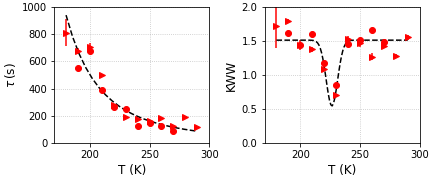

In [13]:
f, (a1,a2) = plt.subplots(1,2, figsize=(6,2.5), constrained_layout=True)

a1.errorbar(T1, tau1, yerr=dtau1, fmt='o',ls='', color='r', label='2021' )
a1.errorbar(T2, tau2, yerr=dtau2, fmt='>',ls='', color='r', label='2022' )
# a1.errorbar(T, tau, yerr=dtau, fmt='o',ls='', color='r', label='data' )
popt2,xc2,curve2,perr2 = fit(arrhenius, T, tau, sigma=dtau, p0=[15e4, 1e3])
a1.plot(xc2, curve2, ls='--', c='k', label='fit')

a2.errorbar(T1, alpha1, yerr=dalpha_fake, marker='o',ls='', color='r', label='2021' )
a2.errorbar(T2, alpha2, yerr=dalpha2, fmt='>',ls='', color='r', label='2022' )
# a2.plot(T, alpha, marker='o',ls='', color='r', label='data')
popt,xc,curve,perr = fit(gaussian_inv, T, alpha, p0=[.8,230,6.,1.5], xc_len=True)
a2.plot(xc, curve, ls='--', c='k', label='fit')

a1.grid(ls=':',color='gray',alpha=.5)
a1.set_xlim(170,300)
a1.set_ylim(0,1000)
a1.set_xlabel('T (K)', fontsize=12)
a1.set_ylabel(r'$\tau\,(\mathrm{s})$', fontsize=12)
# a1.legend()

a2.grid(ls=':',color='gray',alpha=.5)
a2.set_xlim(170,300)
a2.set_ylim(0,2)
a2.set_xlabel('T (K)', fontsize=12)
a2.set_ylabel('KWW', fontsize=12)#r'$\alpha$')
# a2.legend(loc='lower right')
# f.savefig('../09-plots/fig3-cd.png', dpi=300)
f.show()

Arrhenius fit:

`def arrhenius(x,t1,Ea):
    Kb = 1
    return t1 * np.exp( Ea/(x*Kb) )`

<IPython.core.display.Javascript object>


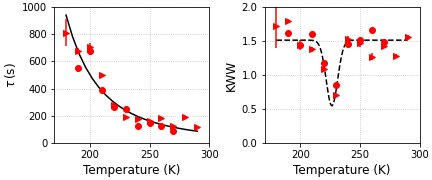

Activation energy: 9.40 $\pm$ 1.1 kJ/mol
Amplitude: 1.8 $\pm$ 1.1
max temp:  226.66666666666669


In [14]:
f, (a1,a2) = plt.subplots(1,2, figsize=(6,2.5), constrained_layout=True)
# a3 = plt.axes([0,0,1,1])
# ip = InsetPosition(a1, [0.55,0.57,0.4,0.4]) #x0,y0, x_length, y_length
# a3.set_axes_locator(ip)

popt2,xc2,curve2,perr2 = fit(arrhenius, T, tau, sigma=dtau, p0=[15e4, 1e3])
a1.plot(xc2, curve2, ls='-', c='k', label='fit')
a1.errorbar(T1, tau1, yerr=dtau1, fmt='o',ls='', color='r', label='2021' )
a1.errorbar(T2, tau2, yerr=dtau2, fmt='>',ls='', color='r', label='2022' )
# a1.errorbar(T, tau, yerr=dtau, fmt='o',ls='', color='r', label='data' )
Kbb = 1.3806e-23 # J/K
Na = 6.02214076e23 
Ea = popt2[1] * Kbb / 1e3 * Na
dEa = perr2[1] * Kbb / 1e3 * Na
print(f"Activation energy: {Ea:.2f} $\pm$ {dEa:.1f} kJ/mol")
print(f"Amplitude: {popt2[0]:.1f} $\pm$ {perr2[0]:.1f}")

# a3.plot(1000/xc2, np.log(curve2), ls='-', c='k', label='Arrhenius fit')
# a3.plot(1000/T1, np.log(tau1), marker='o', ls='', c='r', ms=4)
# a3.plot(1000/T2, np.log(tau2), marker='>', ls='', c='r', ms=4)

a2.errorbar(T1, alpha1, yerr=dalpha_fake, marker='o',ls='', color='r', label='2021' )
a2.errorbar(T2, alpha2, yerr=dalpha2, fmt='>',ls='', color='r', label='2022' )
# a2.plot(T, alpha, marker='o',ls='', color='r', label='data')
popt,xc,curve,perr = fit(gaussian_inv, T, alpha, p0=[.8,230,6.,1.5], xc_len=True)
a2.plot(xc, curve, ls='--', c='k', label='fit')
print("max temp: ",xc[np.argmin(curve)])

a1.grid(ls=':',color='gray',alpha=.5)
a1.set_xlim(170,300)
a1.set_ylim(0,1000)
a1.set_xlabel('Temperature (K)', fontsize=12)
a1.set_ylabel(r'$\tau\,(\mathrm{s})$', fontsize=12)
# a1.legend()

a2.grid(ls=':',color='gray',alpha=.5)
a2.set_xlim(170,300)
a2.set_ylim(0,2)
a2.set_xlabel('Temperature (K)', fontsize=12)
a2.set_ylabel('KWW', fontsize=12)#r'$\alpha$')

# a3.set_ylabel(r'$\ln(\tau$) (s)', fontsize=12, labelpad=0)
# a3.set_xlabel(r'1000/T (K$^{-1}$)', fontsize=12)

# a2.legend(loc='lower right')
f.savefig('../09-plots/fig3-cd-nointset.png', dpi=300)
f.show()

# CMWS newsletter

In [15]:
f = np.load('../02-sources/cmws_chi.npz')
f.files
chi0 = f['chi_0']
T_chi = f['temp']
fitx = f['fit_x']
fity = f['fit_y']

<IPython.core.display.Javascript object>


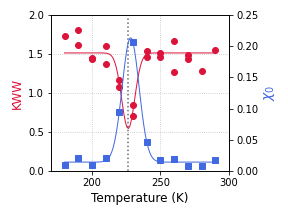

In [17]:
# f, a2 = plt.subplots(1,1, figsize=(4,3), constrained_layout=True)
fig = plt.figure(figsize=(4,3))
a2 = fig.add_subplot(111)
ax1 = a2.twinx()

# c1 = 'firebrick'
c1 = 'crimson'
# c2 = 'dodgerblue'
c2 = 'royalblue'
a2.plot(T1, alpha1, marker='o',ls='', color=c1)
a2.plot(T2, alpha2, marker='o',ls='', color=c1)
popt,xc,curve,perr = fit(gaussian_inv, T, alpha, p0=[.8,230,6.,1.5], xc_len=True)
a2.plot(xc, curve, ls='-', c=c1, lw=1)


ax1.plot(T_chi, chi0,  marker='s',ls='', c=c2)
ax1.plot(fitx, fity, ls='-', c=c2, lw=1)
# ax1.set_ylabel(r'$\chi_0$', fontsize=14, color=c2)
ax1.set_ylabel(r'$\chi_0$', fontsize=14, color=c2)
ax1.set_ylim(0,0.25)

a2.axvline(x=226.5, ls=':', c='k', alpha=0.6)

a2.grid(ls=':',color='gray',alpha=.5)
a2.set_xlim(170,300)
a2.set_ylim(0,2)
a2.set_yticks(np.arange(0,2.1,0.5))
a2.set_xlabel('Temperature (K)', fontsize=12)
a2.set_ylabel('KWW', fontsize=12, color=c1)
plt.tight_layout()
# plt.savefig('../09-plots/cmws2.png', dpi=300)
fig.show()

# Gamma function

In [15]:
from scipy.special import gamma

In [16]:
kww = [0.5, 1.5]
ttau = 200

def corr_tau(kww):
    return gamma(1/kww) / kww

In [17]:
corr_taus = corr_tau(kww, tau=ttau) 

TypeError: corr_tau() got an unexpected keyword argument 'tau'

$\langle\tau\rangle = \tau\,\Gamma(1/\alpha)\,\,/\,\,{\alpha}$

$\lim_{\alpha\to\infty} \Gamma(1/\alpha) = \infty$

In [ ]:
plt.figure()

x = np.linspace(-3.5, 5.5, 2251)
y = gamma(x)

plt.plot(x, y, 'b', alpha=0.6, label='gamma(x)')

for alpha in kww:
    plt.plot(1/alpha, corr_tau(1/alpha), ls='', marker='o', label=f'kww={alpha}')

k = np.arange(1, 7)
plt.xlim(-2, 5)
plt.ylim(-10, 25)
plt.grid(ls=':')
plt.xlabel(r'x = $1/\alpha$')
plt.ylabel(r'$\Gamma(1/\alpha)$')
plt.legend(loc='lower right')
plt.show()

# Fluences

In [ ]:
Flux0 = 6.7e10 #ph/s
# Flux1 = Flux0 / 3
Flux = Flux0 / (100*100) * (30*30)
beam = np.pi*30*30 # um^2

# transmissions
Tr = np.array([1,0.47,0.22, 0.001])

F = Tr*Flux # ph/s
Fl = Tr*Flux/beam # ph/s/um^2

print("Transm \t Flux (ph/s) \t Fluence (ph/s/um^2)")
for i in range(len(Tr)):
    print(f'{Tr[i]} \t {F[i]:.1e} \t {Fl[i]:.1e}')